# Fine-Tuning DeBERTa on the Sentiment Analysis Dataset

## Loading Libraries and Dataset

Installing and importing the required libraries.

In [1]:
!pip install simpletransformers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm.notebook import tqdm
tqdm.pandas()

import csv
import torch
import logging
import itertools

# Import the ClassificationModel module as we need to do multi-class text classification
from simpletransformers.classification import ClassificationModel

import sklearn
from sklearn.metrics import f1_score, accuracy_score

In [3]:
!pip install emoji
from nltk.tokenize import TweetTokenizer
from emoji import demojize
import re

Loading the dataset

In [4]:
sentiment_train_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_text.txt", sep="\t", skip_blank_lines=False, quoting=csv.QUOTE_NONE, header=None)
sentiment_train_df.columns= ["tweet"]
sentiment_train_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_labels.txt", sep="\n", header=None)
sentiment_train_labels.columns= ["label"]

sentiment_val_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_text.txt", sep="\n", skip_blank_lines=False, quoting=csv.QUOTE_NONE, header=None)
sentiment_val_df.columns= ["tweet"]
sentiment_val_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_labels.txt", sep="\n", header=None)
sentiment_val_labels.columns= ["label"]

sentiment_test_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_text.txt", sep="\n", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
sentiment_test_df.columns= ["tweet"]
sentiment_test_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_labels.txt", sep="\n", header=None)
sentiment_test_labels.columns= ["label"]

sentiment_train_df

,tweet
0,"""QT @user In the original draft of the 7th boo..."
1,"""Ben Smith / Smith (concussion) remains out of..."
2,Sorry bout the stream last night I crashed out...
3,Chase Headley's RBI double in the 8th inning o...
4,@user Alciato: Bee will invest 150 million in ...
...,...
45610,"@user \""""So amazing to have the beautiful Lady..."
45611,"9 September has arrived, which means Apple's n..."
45612,Leeds 1-1 Sheff Wed. Giuseppe Bellusci securin...
45613,@user no I'm in hilton head till the 8th lol g...


Making sure that the data is loaded correctly by checking the dimensions of the data frames for the training, validation, and testing datasets to match the dimensions of their corresponding labels dataframes.

In [5]:
# Checking whether the data is loaded correctly by checking the dimensions of the data frames for the training, validation, and testing datasets matches the dimensions of their corresponding labels datasets.
print(sentiment_train_df.shape, sentiment_train_labels.shape)
print(sentiment_val_df.shape, sentiment_val_labels.shape)
print(sentiment_test_df.shape, sentiment_test_labels.shape)

(45615, 1) (45615, 1)
(2000, 1) (2000, 1)
(12284, 1) (12284, 1)


In [6]:
sentiment_train = pd.concat([sentiment_train_df, sentiment_train_labels], axis=1) 
sentiment_val = pd.concat([sentiment_val_df, sentiment_val_labels], axis=1) 
sentiment_test = pd.concat([sentiment_test_df, sentiment_test_labels], axis=1) 

for i in sentiment_train["tweet"][:20]:
    print(i)

"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin" 
"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ" 
Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night. 
Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays 
@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017" 
@user LIT MY MUM 'Kerry the louboutins I wonder how many Willam owns!!! Look Kerry Warner Wednesday!' 
"\"""" SOUL TRAIN\"""" OCT 27 HALLOWEEN SPECIAL ft T.dot FINEST rocking the mic...CRAZY CACTUS NIGHT CLUB ..ADV ticket $10 wt out costume $15..." 
So disappointed in wwe summerslam! I want to see john cena wins his 16th title 
"This is the last Sunday w/o football .....,NFL is back baby" 
@user @user CENA 

## Exploratory Data Analysis

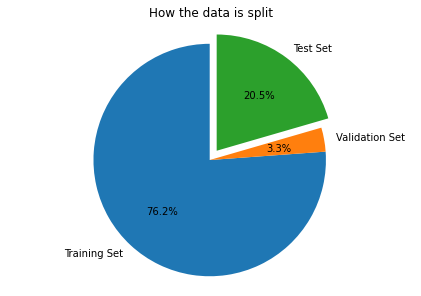

In [7]:
# Pie chart
labels = ['Training Set', 'Validation Set', 'Test Set']
sizes = [len(sentiment_train_labels), len(sentiment_val_labels), len(sentiment_test_labels)]
explode = (0, 0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("How the data is split")
plt.show()

In [8]:
# Checking the labels
sentiment_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/mapping.txt", sep="\t", header=None)
sentiment_labels

,0,1
0,0,negative
1,1,neutral
2,2,positive


Data statitics:

In [9]:
print("Training Data Statistics: ")
print("Total number of tweets:", sentiment_train_labels.shape[0])
print("Number of Negative tweets:", int(sentiment_train_labels.value_counts()[0]))
print("Number of Neutral tweets:", int(sentiment_train_labels.value_counts()[1]))
print("Number of Positive tweets:", int(sentiment_train_labels.value_counts()[2]),"\n")

print("Validation Data Statistics: ")
print("Total number of tweets:", sentiment_val_labels.shape[0])
print("Number of Negative tweets:", int(sentiment_val_labels.value_counts()[0]))
print("Number of Neutral tweets:", int(sentiment_val_labels.value_counts()[1]))
print("Number of Positive tweets:", int(sentiment_val_labels.value_counts()[2]),"\n")

print("Testing Data Statistics: ")
print("Total number of tweets:", sentiment_test_labels.shape[0])
print("Number of Negative tweets:", int(sentiment_test_labels.value_counts()[0]))
print("Number of Neutral tweets:", int(sentiment_test_labels.value_counts()[1]))
print("Number of Positive tweets:", int(sentiment_test_labels.value_counts()[2]))

Training Data Statistics: 
Total number of tweets: 45615
Number of Negative tweets: 7093
Number of Neutral tweets: 20673
Number of Positive tweets: 17849 

Validation Data Statistics: 
Total number of tweets: 2000
Number of Negative tweets: 312
Number of Neutral tweets: 869
Number of Positive tweets: 819 

Testing Data Statistics: 
Total number of tweets: 12284
Number of Negative tweets: 3972
Number of Neutral tweets: 5937
Number of Positive tweets: 2375


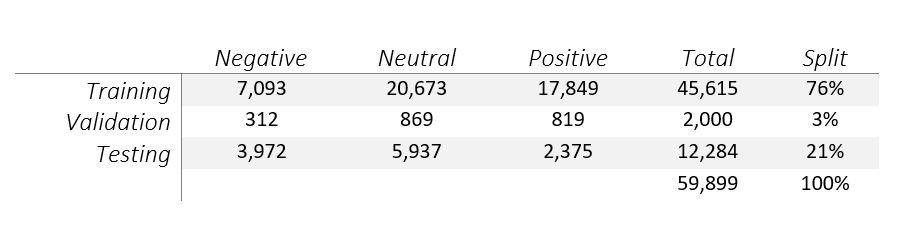

In [10]:
data = sentiment_train_labels.groupby("label").sum()
data

""
label
0
1
2


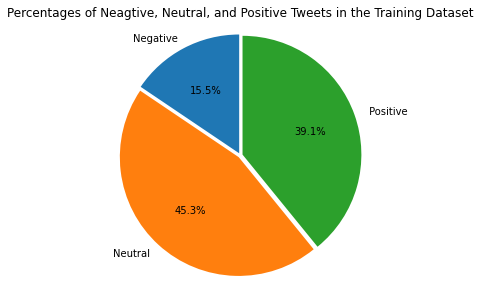

In [11]:
# Pie chart
senti_neg_count = sentiment_train_labels[sentiment_train_labels.label == 0].shape[0]
senti_neut_count = sentiment_train_labels[sentiment_train_labels.label == 1].shape[0]
senti_pos_count = sentiment_train_labels[sentiment_train_labels.label == 2].shape[0]

labels = ['Negative', 'Neutral', ' Positive']
sizes = [senti_neg_count, senti_neut_count, senti_pos_count]
fig1, ax1 = plt.subplots()
explode = (0.02, 0.02, 0.02)  
ax1.pie(sizes, explode= explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Percentages of Neagtive, Neutral, and Positive Tweets in the Training Dataset")
plt.show()

[Text(0, 0, 'Negative'), Text(0, 0, 'Neutral'), Text(0, 0, ' Positive')]

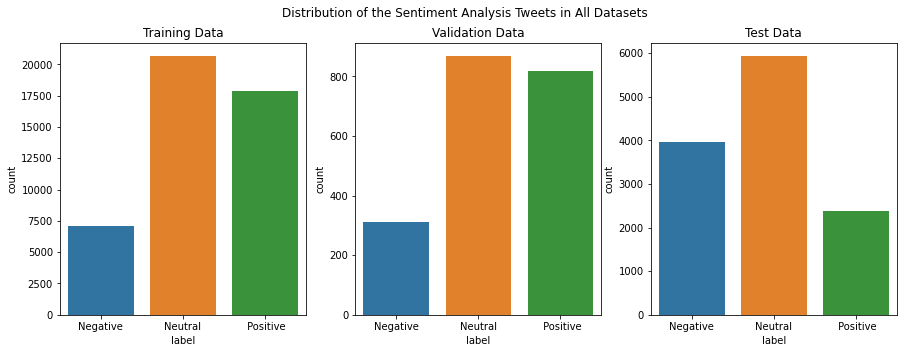

In [12]:
# Count Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle('Distribution of the Sentiment Analysis Tweets in All Datasets')

sns.countplot(ax=axes[0], x=sentiment_train_labels.label)
axes[0].set_title('Training Data')
axes[0].set_xticklabels(labels)

sns.countplot(ax=axes[1], x=sentiment_val_labels.label)
axes[1].set_title('Validation Data')
axes[1].set_xticklabels(labels)

sns.countplot(ax=axes[2], x=sentiment_test_labels.label)
axes[2].set_title('Test Data')
axes[2].set_xticklabels(labels)

## Exploring the tokenization and attention mask process

In [13]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Emojis are not recognized by the tokenizer so they are tokenized as [UNK].


In [14]:
sentiment_train_df.iloc[30,0]

'"#Ichiro has nothing. If you want to see hustle: Kenny Lofton, 17 October 1995, scores from second base on a past ball. #GoTribe #ALDS" '

In [15]:
# tokenizing and removing white spaces while keepng punctuation
tweet_sample = sentiment_train_df.iloc[30,0]
token_sample = tokenizer.tokenize(tweet_sample)
print(token_sample)

['"', '#', 'ich', '##iro', 'has', 'nothing', '.', 'if', 'you', 'want', 'to', 'see', 'hu', '##stle', ':', 'kenny', 'loft', '##on', ',', '17', 'october', '1995', ',', 'scores', 'from', 'second', 'base', 'on', 'a', 'past', 'ball', '.', '#', 'got', '##ri', '##be', '#', 'al', '##ds', '"']


Converting the corpus into tokens and then converting each token to its ID, which is a unique integer representing the index of that token in the vocabulary of the model.


In [16]:
token_id_sample = tokenizer.convert_tokens_to_ids(token_sample)
print(token_id_sample)

[1000, 1001, 22564, 9711, 2038, 2498, 1012, 2065, 2017, 2215, 2000, 2156, 15876, 22516, 1024, 8888, 19459, 2239, 1010, 2459, 2255, 2786, 1010, 7644, 2013, 2117, 2918, 2006, 1037, 2627, 3608, 1012, 1001, 2288, 3089, 4783, 1001, 2632, 5104, 1000]


We have to provide sequences of equal length therefore we'll add some padding, then pass "attention mask" where each term has a value of 1 and each padding token has a value of 0.

Special tokens are needed for separating betwen sentences, that's how BERT initially trained on squence classification.

Exploring types of tokens when encoding them into IDs:


In [17]:
print("Types of tokens and their IDs:", tokenizer.special_tokens_map)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id) # CLS is sequence/text classification task
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.mask_token, tokenizer.mask_token_id)

Types of tokens and their IDs: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}
[PAD] 0
[UNK] 100
[CLS] 101
[SEP] 102
[MASK] 103


Exploring the encoding process

In [18]:
encoding = tokenizer.encode_plus( # why plus?
        
    text = tweet_sample,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    # pad_to_max_length=True,
    truncation=True,
    max_length=60, # number of tokens
    padding='max_length',
    return_attention_mask = True,
    return_tensors='pt',  # Return PyTorch tensors, and tf can be used for TensorFlow as well
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The Attention Mask giving the values of 1 to all tokens, except the padding tokens in which it gives them the value of 0.

In [19]:
encoded_seq = encoding['input_ids'][0]
print("Encoded sequence (IDs):\n", encoded_seq)
print("Attention Mask:\n", encoding['attention_mask'])

Encoded sequence (IDs):
 tensor([  101,  1000,  1001, 22564,  9711,  2038,  2498,  1012,  2065,  2017,
         2215,  2000,  2156, 15876, 22516,  1024,  8888, 19459,  2239,  1010,
         2459,  2255,  2786,  1010,  7644,  2013,  2117,  2918,  2006,  1037,
         2627,  3608,  1012,  1001,  2288,  3089,  4783,  1001,  2632,  5104,
         1000,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Attention Mask:
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Choosing the right size of sequence (or number of tokens) for our dataset is necessary because the larger the sequence length the slower is the process of training the model since there is a corelation between the two.

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


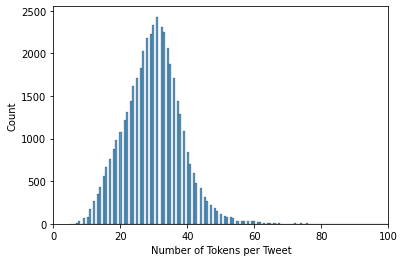

In [20]:
token_lens = []

for each_tweet in sentiment_train_df.tweet:
  
  tokens = tokenizer.encode(each_tweet, max_length=512) # max length by the model
  token_lens.append(len(tokens)) 


sns.histplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Number of Tokens per Tweet'); 

## Pre-Processing Steps

In [21]:
# Checking for null values

print("Number of NULL values in the sentiment recognition training set: ", sentiment_train_df['tweet'].isnull().values.sum())
print("Number of NULL values in the sentiment recognition validation set: ", sentiment_val_df['tweet'].isnull().values.sum())
print("Number of NULL values in the sentiment recognition test set: ", sentiment_test_df['tweet'].isnull().values.sum(), '\n')

Number of NULL values in the sentiment recognition training set:  0
Number of NULL values in the sentiment recognition validation set:  0
Number of NULL values in the sentiment recognition test set:  0 



In [22]:
tokenizer = TweetTokenizer()

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token

def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = normTweet.replace("cannot ", "can not ").replace("n't ", " n't ").replace("n 't ", " n't ").replace("ca n't", "can't").replace("ai n't", "ain't")
    normTweet = normTweet.replace("'m ", " 'm ").replace("'re ", " 're ").replace("'s ", " 's ").replace("'ll ", " 'll ").replace("'d ", " 'd ").replace("'ve ", " 've ")
    normTweet = normTweet.replace(" p . m .", "  p.m.") .replace(" p . m ", " p.m ").replace(" a . m .", " a.m.").replace(" a . m ", " a.m ")

    normTweet = re.sub(r",([0-9]{2,4}) , ([0-9]{2,4})", r",\1,\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3}) / ([0-9]{2,4})", r"\1/\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3})- ([0-9]{2,4})", r"\1-\2", normTweet)
    normTweet = normTweet.replace('@USER', '')
    normTweet = normTweet.replace('HTTPURL', '')
    return " ".join(normTweet.split())

# Testing the pre-processing functions
print(normalizeTweet("SC has first two presumptive cases of coronavirus, DHEC confirms https://postandcourier.com/health/covid19/ … via @postandcourier"))
print(normalizeTweet("So. Many. Plot twists. 😩😭😭😭😭 #Westworld #WestworldFinale "))
print(normalizeTweet("@user @user @user Tamra would F her up if she swung on Tamra\nKelly is a piece of 💩 #needstobeadmitted #bully"))
print(normalizeTweet("in my dream....They were trying to steal my kidney!!!  #blackmarket #whydidiwatchthat "))

SC has first two presumptive cases of coronavirus , DHEC confirms ... via
So . Many . Plot twists . :weary_face: :loudly_crying_face: :loudly_crying_face: :loudly_crying_face: #Westworld #WestworldFinale
Tamra would F her up if she swung on Tamra Kelly is a piece of :pile_of_poo: #needstobeadmitted #bully
in my dream ... They were trying to steal my kidney ! ! ! #blackmarket #whydidiwatchthat


In [23]:
!pip install ekphrasis
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

In [24]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",
    #    'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

def preprocess_tweets(s):
    s = " ".join(text_processor.pre_process_doc(s))
    s = ' '.join(k for k, _ in itertools.groupby(s.split()))
    s = s.replace("' ", "'").replace(" '", "'")
    s = " ".join(s.split())
    s = s.strip()
    s = s.replace('“', "")
    # s = s.replace("<user>", '')
    # s = demojize(s)
    return s
    
# Test Sentences
sentences = [
    "CANT WAIT for the new season of #TwinPeaks ＼(^o^)／!!! #davidlynch #tvseries :)))",
    "I saw the new #johndoe movie and it suuuuucks!!! WAISTED $10... #badmovies :/",
    "@SentimentSymp:  can't wait for the Nov 9 #Sentiment talks!  YAAAAAAY !!! :-D http://sentimentsymposium.com/.",
    "'You have a #problem? Yes! Can you do #something about it? No! Than why  '",
    "on the bright side , my music theory teacher just pocket dabbed and said ,'i know what's hip .'and walked away "
]

for i in sentences:
    print(preprocess_tweets(i))

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...
cant wait for the new season of twin peaks ＼(^o^)／ ! david lynch tv series <happy>
i saw the new john doe movie and it suuuuucks ! waisted <money> . bad movies <annoyed>
<user> : can not wait for the <date> sentiment talks ! yaaaaaay ! <laugh> <url>
'you have a problem ? yes ! can you do something about it ? no ! than why'
on the bright side , my music theory teacher just pocket dabbed and said ,'i know what's hip .'and walked away


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [25]:
sentiment_train['tweet'] = sentiment_train['tweet'].apply(lambda x: preprocess_tweets(x))
sentiment_val['tweet'] = sentiment_val['tweet'].apply(lambda x: preprocess_tweets(x))
sentiment_test['tweet'] = sentiment_test['tweet'].apply(lambda x: preprocess_tweets(x))

del sentiment_train_df, sentiment_train_labels, sentiment_val_df, sentiment_val_labels, sentiment_test_df, sentiment_test_labels

In [26]:
sentiment_train.head()

,tweet,label
0,""" qt <user> in the original draft of the 7 th ...",2
1,""" ben smith / smith ( concussion ) remains out...",1
2,sorry bout the stream last night i crashed out...,1
3,chase headley's rbi double in the 8 th inning ...,1
4,<user> alciato : bee will invest <number> mill...,2


In [27]:
sentiment_train.label.value_counts()

1    20673
2    17849
0     7093
Name: label, dtype: int64

In [28]:
# pre-processed/clean input
for i in sentiment_train["tweet"][:20]:
    print(i)

" qt <user> in the original draft of the 7 th book , remus lupin survived the battle of hogwarts . happy birthday remus lupin "
" ben smith / smith ( concussion ) remains out of the lineup thursday , curtis nhl sj "
sorry bout the stream last night i crashed out but will be on tonight for sure . then back to minecraft in pc tomorrow night .
chase headley's rbi double in the 8 th inning off david price snapped a yankees streak of <number> consecutive scoreless innings against blue jays
<user> alciato : bee will invest <number> million in january , another <number> in the summer and plans to bring messi by <number> "
<user> lit my mum'kerry the louboutins i wonder how many willam owns ! look kerry warner wednesday !'
" \ " soul train \ " oct <number> halloween special ft t . dot finest rocking the mic . crazy cactus night club . adv ticket <money> wt out costume <money> . "
so disappointed in wwe summerslam ! i want to see john cena wins his 1 6 th title
" this is the last sunday w / o f

## Fine-Tuning and Evaluating the Model

In [29]:
import wandb

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

cuda_available = torch.cuda.is_available()
print(cuda_available)


train_args = {
              'manual_seed':41,
              'save_steps' : 2000,
              'save_model_every_epoch' : True,
              'save_eval_checkpoints' : True, # s false
              "warmup_steps": 100, # s 100
              'use_early_stopping' : True, # False
              'early_stopping_delta' : 0.01, # s 0.01
              'early_stopping_metric' : "eval_loss", # s mcc
              'early_stopping_metric_minimize' : True, #True
              'early_stopping_patience' : 5, # s 5
              'evaluate_during_training_steps' : 400, # 2000
              'no_cache' : True, # False
              'num_train_epochs':2, 
              'train_batch_size':32, # 8
              'eval_batch_size': 32,
              'max_seq_length':100, # 128
              'learning_rate':4e-5,
              'optimizer': "AdamW",
              'use_tensorboard': True,
              'evaluate_during_training': True,
              'overwrite_output_dir': True, 
              "use_multiprocessing": False, # False
              "use_multiprocessing_for_evaluation" : False,
              "use_multiprocessed_decoding" : False,
              'wandb_project': "CE888"}

trained_model = ClassificationModel('deberta', 
                                    'microsoft/deberta-base', 
                                    num_labels=3, 
                                    use_cuda=True, 
                                    #cuda_device=0, 
                                    args=train_args)

True


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight

In [30]:
trained_model.train_model(sentiment_train, eval_df=sentiment_val)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:449: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.
wandb: Currently logged in as: ihab09 (use `wandb login --relogin` to force relogin)


Running Epoch 0 of 2:   0%|          | 0/1426 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:760: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1029: UserWarning: Datafr

Running Epoch 1 of 2:   0%|          | 0/1426 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Curren

(2852,
 {'eval_loss': [0.6680056367601667,
   0.6236404057533022,
   0.6186559294897412,
   0.5981696952903082,
   0.6222949832204788,
   0.6367537109624772,
   0.6490029815643553,
   0.6253722433059935,
   0.6225517794253335],
  'global_step': [400, 800, 1200, 1426, 1600, 2000, 2400, 2800, 2852],
  'mcc': [0.5361178360021306,
   0.5595020615907493,
   0.5491764281708084,
   0.583259422466289,
   0.5928424529174968,
   0.6011734645814777,
   0.5818514485802653,
   0.585874588164417,
   0.5868765780728247],
  'train_loss': [0.508955717086792,
   0.5524308085441589,
   0.5104753971099854,
   0.5296505093574524,
   0.33190804719924927,
   0.31824663281440735,
   0.570387601852417,
   0.46540918946266174,
   0.28875473141670227]})

In [31]:
from sklearn.metrics import f1_score, accuracy_score

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')

from sklearn.metrics import recall_score

def macro_recall(labels, preds):
    return recall_score(labels, preds, average='macro')

result, model_outputs, wrong_predictions = trained_model.eval_model(sentiment_test, mavg_f1=f1_multiclass, acc=accuracy_score, mavg_recall = macro_recall)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1029: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Running Evaluation:   0%|          | 0/384 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


Training loss,0.47069
lr,0.0
global_step,2852
_runtime,564
_timestamp,1619416411
_step,65
mcc,0.58688
train_loss,0.28875
eval_loss,0.62255


Training loss,█▇▆▃▄▃▅▄▄▅▅▄▅▄▄▅▅▆▃▄▂▂▂▁▅▂▃▂▃▁▂▂▄▄▃▁▂▄▃▃
lr,▄███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
mcc,▁▄▂▆▇█▆▆▆
train_loss,▆█▇▇▂▂█▅▁
eval_loss,█▄▃▁▃▅▆▄▃


wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5379193184611978, 'eval_loss': 0.7023253443961343, 'mavg_f1': 0.7042909346518739, 'acc': 0.7037609899055682, 'mavg_recall': 0.7202241004978521}


Graphs showing the training process as imported from the Weights and Biases platform (wandb.ai).

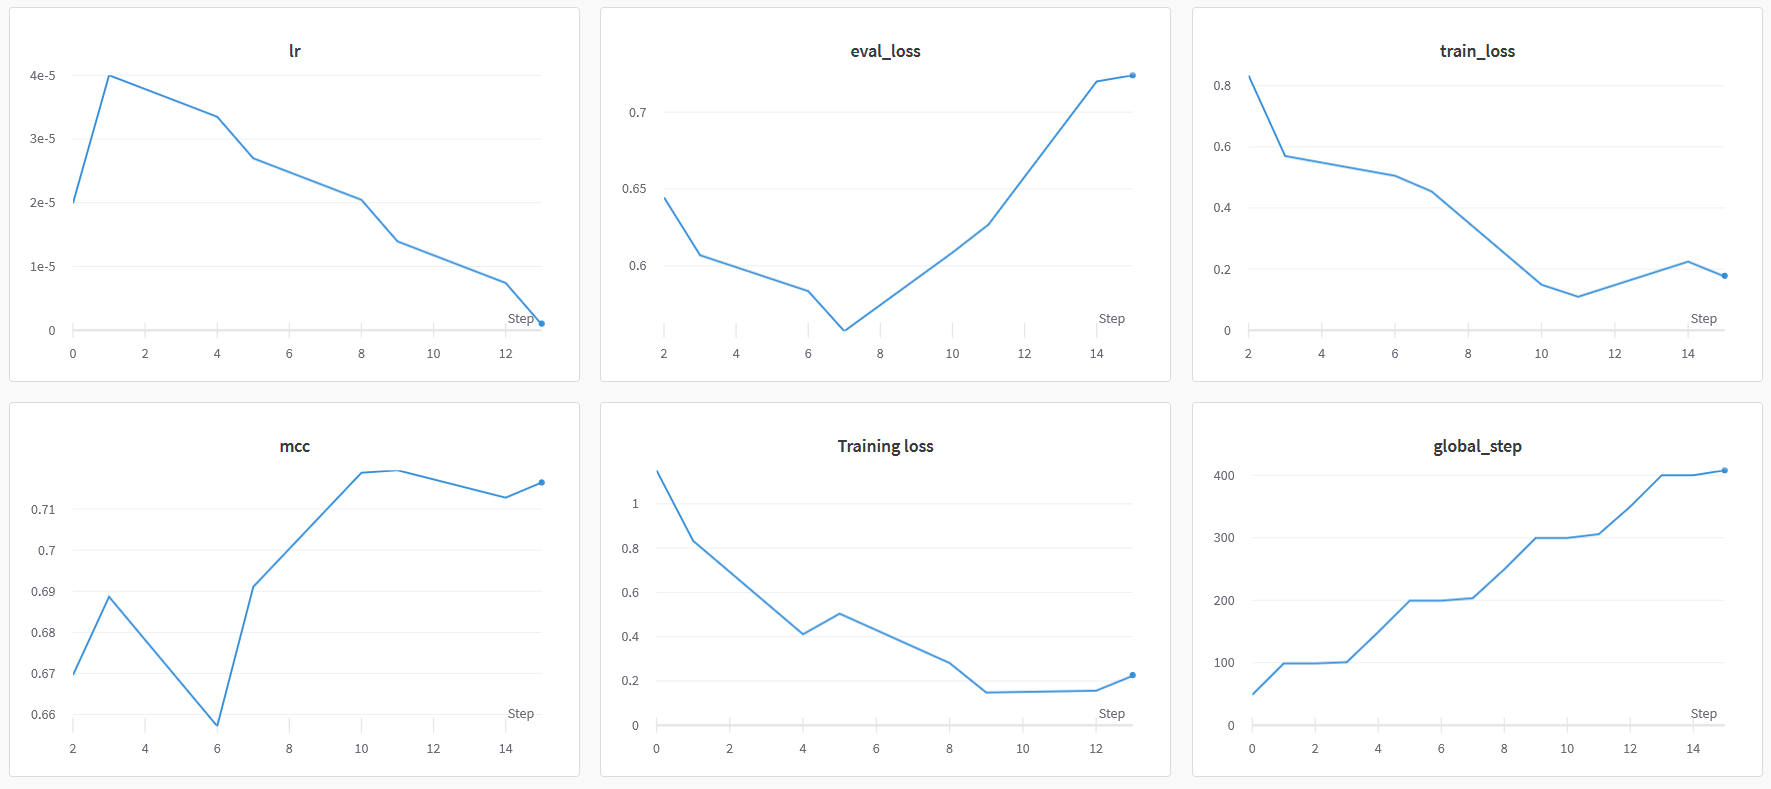

The confustion matrix showing that the first class "Anger" is correctly classified most of the time, while the third class "Joy" is widely missclassified. 

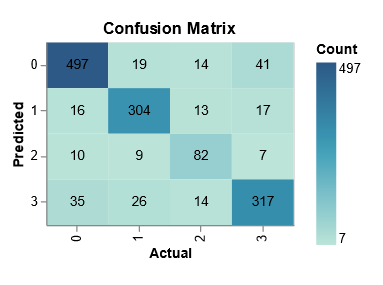

In [32]:
result

{'acc': 0.7037609899055682,
 'eval_loss': 0.7023253443961343,
 'mavg_f1': 0.7042909346518739,
 'mavg_recall': 0.7202241004978521,
 'mcc': 0.5379193184611978}

### Macro-Averaged Recall Score

In [33]:
print("Macro-Averaged Recall: ", result['mavg_recall']*100)

Macro-Averaged Recall:  72.02241004978521


In [34]:
# Plays an audio message as a notification when the training process is done.
import IPython.display as display
display.Audio(url="https://static.sfdict.com/audio/C07/C0702600.mp3", autoplay=True)

## Saving the best model

In [ ]:
# Transforming the model folder into a single compressed file.
!zip -r /content/outputs/best_model_file.zip /content/outputs/best_model

In [ ]:
# Downloading the model locally.
from google.colab import files
files.download("/content/outputs/best_model_file.zip")

## Loading the saved model

In [ ]:
# If you don't want to retrain the model, you can load the best saved model directly by running the code below.
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

cuda_available = torch.cuda.is_available()
print(cuda_available)

import wandb

trained_model = ClassificationModel(
    "deperta", "outputs/best_model"
    # "bertweet", "outputs/checkpoint-612-epoch-6"
)